# Introduction to Time Series Forecasting

<a> https://ucilnica.fri.uni-lj.si/mod/resource/view.php?id=28089 <a>

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Libraries for Plotting

from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
# Libraries for model selection

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [4]:
# adjust display settings

%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Data Preparation

### Load and Explore Time Series Data

In [5]:
# load dataset

dataframe = pd.read_csv('FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [6]:
# display first few lines of a time series

dataframe.head()

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.06
1954-10-01,0.85
1954-11-01,0.83


In [7]:
# the index is in datetime format, which is fine

dataframe.index[:5]

DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01', '1954-10-01',
               '1954-11-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [8]:
# however, this doesn't look good yet

dataframe.head().values

array([[0.8 ],
       [1.22],
       [1.06],
       [0.85],
       [0.83]], dtype=float32)

In [9]:
# unstacking the data might help...

dataframe.unstack().head()

          DATE      
FEDFUNDS  1954-07-01   0.80
          1954-08-01   1.22
          1954-09-01   1.06
          1954-10-01   0.85
          1954-11-01   0.83
dtype: float32

In [10]:
# and it does

dataframe.unstack().head().values

array([0.8 , 1.22, 1.06, 0.85, 0.83], dtype=float32)

#### Create Time Series

Pandas represents time series datasets as a Series. A Series is a one-dimensional array with a time label for each row.

In [11]:
# create a time series

s = pd.Series(dataframe.unstack().values, index=dataframe.index)

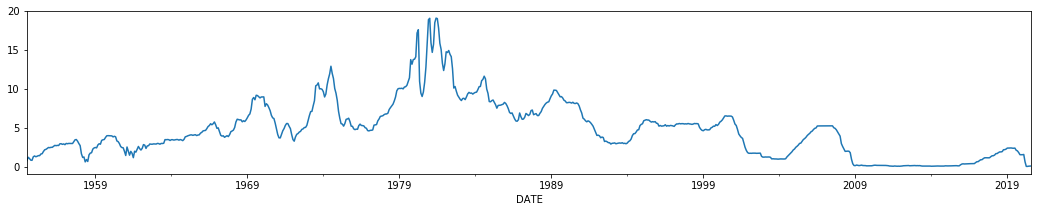

In [12]:
# basic plot
s.plot()

In [13]:
# query a dataset using a date-time index

# This and the following step is for Train-test split (80:20 proportion)
# This is for Train sample

# In "our" case since we have a short data, that's why we will not split it into train and test datasets:

s[:'2007'].tail(10)

DATE
2007-03-01   5.26
2007-04-01   5.25
2007-05-01   5.25
2007-06-01   5.25
2007-07-01   5.26
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
dtype: float32

In [14]:
# keep only data before 2008 
s = s[:'2007']

#### Explore Time Series Data

In [15]:
# display first few lines of a time series
s.head()

DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.06
1954-10-01   0.85
1954-11-01   0.83
dtype: float32

In [16]:
s.index[:5]

DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01', '1954-10-01',
               '1954-11-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [17]:
# display last few lines of a time series
s.tail()

DATE
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
dtype: float32

In [18]:
# summarize the dimensions of a time series

s.size

642

In [19]:
# calculate descriptive statistics

s.describe()

count   642.00
mean      5.69
std       3.32
min       0.63
25%       3.29
50%       5.25
75%       7.30
max      19.10
dtype: float64

#### Basic Feature Engineering

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms. There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

A time series dataset must be transformed to be modeled as a supervised learning problem. We need to transform something that looks like:

* time 1, value 1
* time 2, value 2
* time 3, value 3

into something that looks like:

* input 1, output 1
* input 2, output 2
* input 3, output 3

##### Date Time Features

In [20]:
# The simplest features that we can use are features from the date/time of each observation.

df = pd.DataFrame()
df['year'] = [s.index[i].year for i in range(len(s))]
df['month'] = [s.index[i].month for i in range(len(s))]
df['value'] = s.values.tolist()

In [21]:
df.head()

,year,month,value
0,1954,7,0.80
1,1954,8,1.22
2,1954,9,1.06
3,1954,10,0.85
4,1954,11,0.83


#### Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:

* Value(t), Value(t+1)
* Value(t), Value(t+1)
* Value(t), Value(t+1)

In [22]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [23]:
df.head()

,t,t+1
0,nan,0.80
1,0.80,1.22
2,1.22,1.06
3,1.06,0.85
4,0.85,0.83


In [24]:
df.tail()

,t,t+1
637,5.26,5.02
638,5.02,4.94
639,4.94,4.76
640,4.76,4.49
641,4.49,4.24


#### WIndow Features

The addition of lag features is called the sliding window method, in this case with a window width of 1. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width. We can expand the window width and include more lagged features.

In [25]:
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
df.columns = ['t-2', 't-1', 't', 't+1']

In [26]:
df.head()

,t-2,t-1,t,t+1
0,nan,nan,nan,0.80
1,nan,nan,0.80,1.22
2,nan,0.80,1.22,1.06
3,0.80,1.22,1.06,0.85
4,1.22,1.06,0.85,0.83


In [27]:
df.tail()

,t-2,t-1,t,t+1
637,5.25,5.25,5.26,5.02
638,5.25,5.26,5.02,4.94
639,5.26,5.02,4.94,4.76
640,5.02,4.94,4.76,4.49
641,4.94,4.76,4.49,4.24


#### Rolling Window Statistics

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. Perhaps the most useful is the mean of the previous values, also called the rolling mean.

In [28]:
values = pd.DataFrame(s.values)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

df = pd.concat([means, values], axis=1)
df.columns = ['mean(t-1,t)', 't+1']

In [29]:
df.head()

,"mean(t-1,t)",t+1
0,nan,0.80
1,nan,1.22
2,1.01,1.06
3,1.14,0.85
4,0.95,0.83


In [30]:
df.tail()

,"mean(t-1,t)",t+1
637,5.26,5.02
638,5.14,4.94
639,4.98,4.76
640,4.85,4.49
641,4.62,4.24


In [31]:
# Another one:

values = pd.DataFrame(s.values)
width = 3
shifted = values.shift(width - 1)
window = shifted.rolling(window=width)

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [32]:
df.head()

,min,mean,max,t+1
0,nan,nan,nan,0.80
1,nan,nan,nan,1.22
2,nan,nan,nan,1.06
3,nan,nan,nan,0.85
4,0.80,1.03,1.22,0.83


In [33]:
df.head()

,min,mean,max,t+1
0,nan,nan,nan,0.80
1,nan,nan,nan,1.22
2,nan,nan,nan,1.06
3,nan,nan,nan,0.85
4,0.80,1.03,1.22,0.83


#### Expanding Window Statistics

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.

In [34]:
values = pd.DataFrame(s.values)
window = values.expanding()

df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
df.columns = ['min', 'mean', 'max', 't+1']

In [35]:
df.head()

,min,mean,max,t+1
0,0.80,0.80,0.80,0.80
1,0.80,1.01,1.22,1.22
2,0.80,1.03,1.22,1.06
3,0.80,0.98,1.22,0.85
4,0.80,0.95,1.22,0.83


In [36]:
df.tail()

,min,mean,max,t+1
637,0.63,5.70,19.10,5.02
638,0.63,5.70,19.10,4.94
639,0.63,5.69,19.10,4.76
640,0.63,5.69,19.10,4.49
641,0.63,5.69,19.10,4.24


#### Data Visualization

Time series lends itself naturally to visualization. Line plots of observations over time are popular, but there is a suite of other plots that you can use to learn more about your problem. The more you learn about your data, the more likely you are to develop a better forecasting model.

##### Line Plot

Perhaps the most popular visualization for time series is the line plot. In this plot, time is shown on the x-axis with observation values along the y-axis

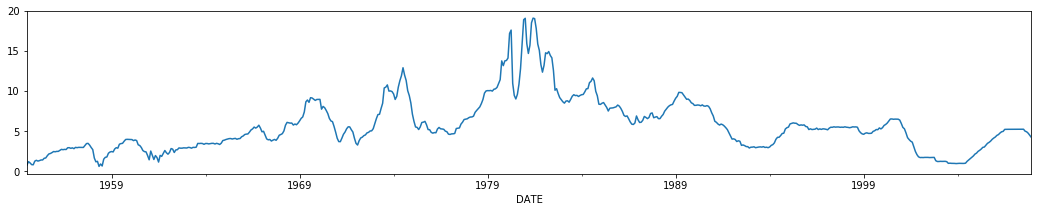

In [37]:
s.plot()

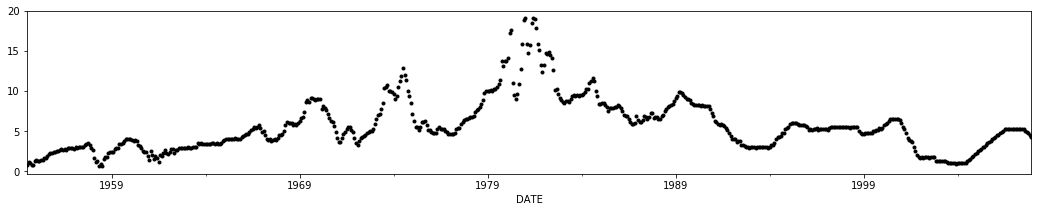

In [38]:
s.plot(style='k.');

#### Histogram and Density Plots

Another important visualization is of the distribution of observations themselves. This means a plot of the values without the temporal ordering. Some linear time series forecasting methods assume a well-behaved distribution of observations (i.e. a bell curve or normal distribution). This can be explicitly checked using tools like statistical hypothesis tests. But plots can provide a useful first check of the distribution of observations both on raw observations and after any type of data transform has been performed.

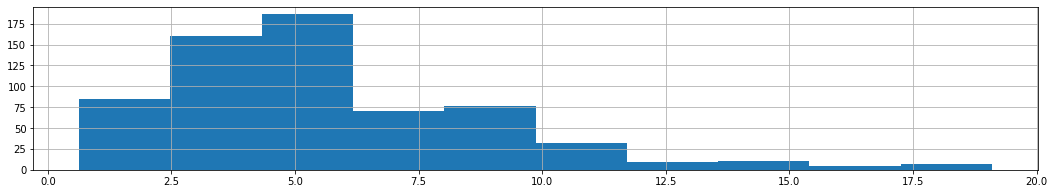

In [39]:
s.hist();

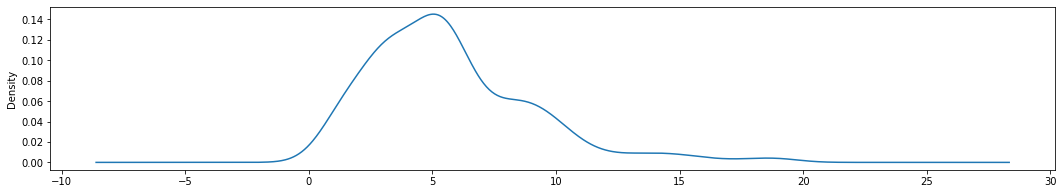

In [40]:
s.plot(kind='kde');

#### Lag Scatter Plots

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag=1, the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.

* If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
* If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
* Either relationship is good as they can be modeled.

More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship. A ball in the middle or a spread across the plot suggests a weak or no relationship.

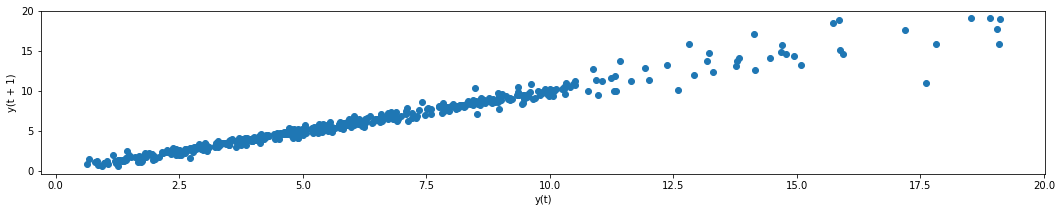

In [41]:
# create a scatter plot

lag_plot(s);

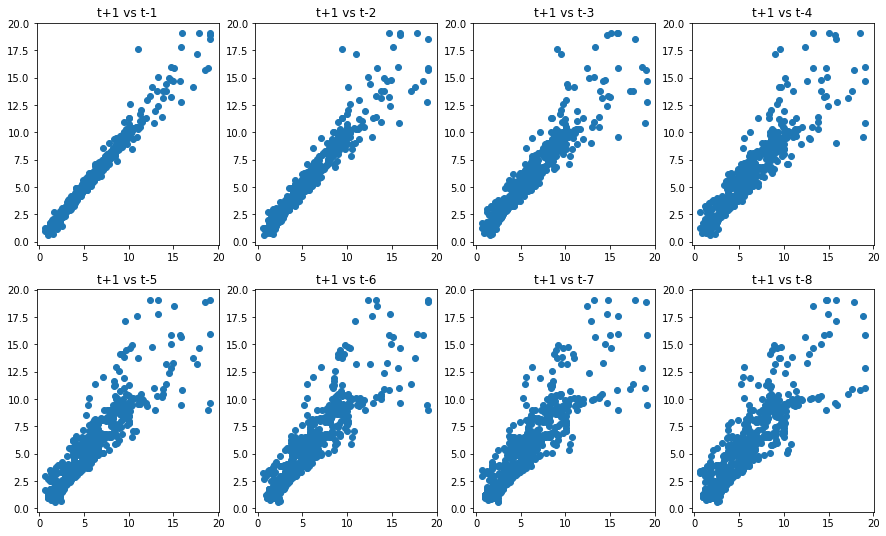

In [42]:
# create multiple scatter plots

values = pd.DataFrame(s.values)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)

#### Autocorrelation Plots

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.

Correlation values, called correlation coeficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot.

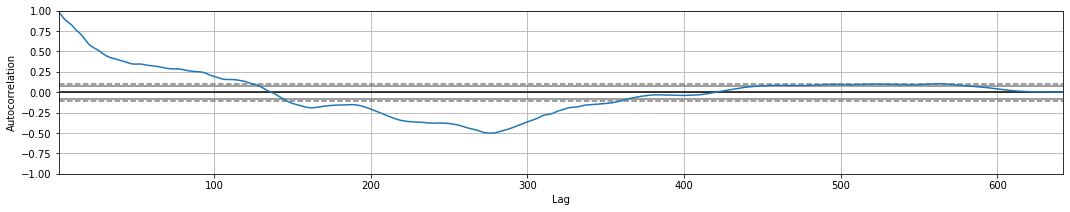

In [43]:
# create an autocorrelation plot

autocorrelation_plot(s);

The Statsmodels library also provides a version of the autocorrelation plot as a line plot. Plots lags on the horizontal and the correlations on vertical axis.

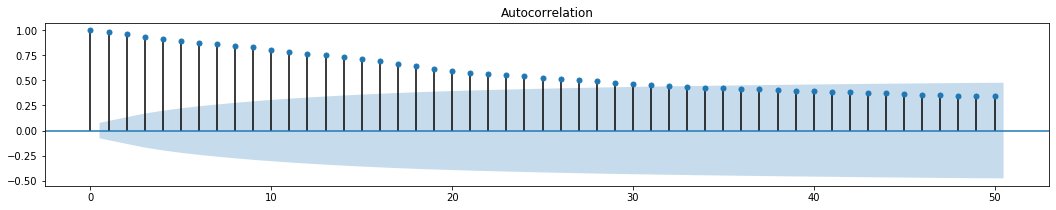

In [44]:
# autocorrelation plot of time series as a line plot

plot_acf(s, lags=50)
plt.show();

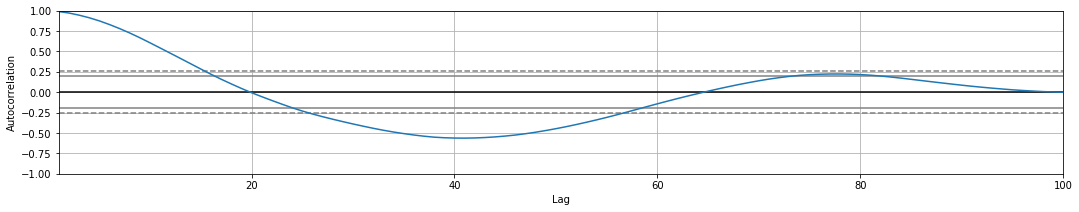

In [45]:
# create an autocorrelation plot, using only the last 100 entries

autocorrelation_plot(s[-100:]);

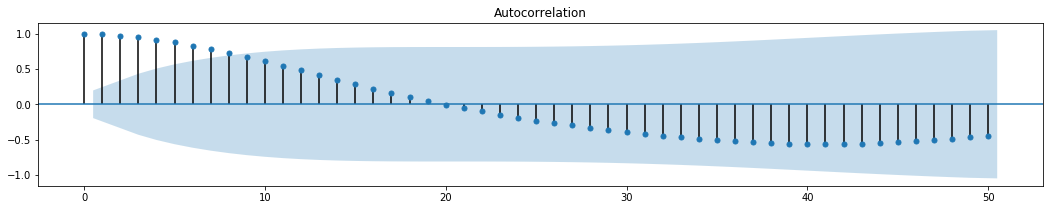

In [46]:
# autocorrelation plot of time series as a line plot

plot_acf(s[-100:], lags=50)
plt.show()

#### Moving Average Smoothing

Moving average smoothing is a naive and effective technique in time series forecasting. It can be used for data preparation, feature engineering, and even directly for making predictions. Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

In [47]:
# tail-rolling average transform

rolling = s.rolling(window=3)
rolling_mean = rolling.mean()

In [48]:
rolling_mean.head(10)

DATE
1954-07-01    nan
1954-08-01    nan
1954-09-01   1.03
1954-10-01   1.04
1954-11-01   0.91
1954-12-01   0.99
1955-01-01   1.17
1955-02-01   1.32
1955-03-01   1.34
1955-04-01   1.36
dtype: float64

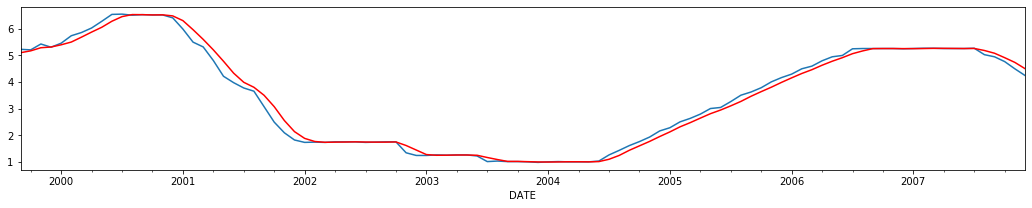

In [49]:
# plot original and transformed dataset
s[-100:].plot()
rolling_mean[-100:].plot(color='red');

In [50]:
s[-100:].head()

DATE
1999-09-01   5.22
1999-10-01   5.20
1999-11-01   5.42
1999-12-01   5.30
2000-01-01   5.45
dtype: float32

#### Moving Average as Prediction

The moving average value can also be used directly to make predictions. It is a naive model and assumes that the trend and seasonality components of the time series have already been removed or adjusted for. The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day.

In [51]:
# prepare problem

X = s.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test

for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))

In [52]:
print('RMSE: %.3f' % rmse)

RMSE: 0.817


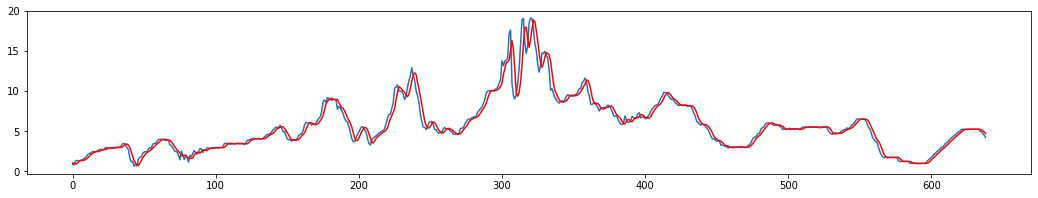

In [53]:
# plot

plt.plot(test)
plt.plot(predictions, color='red')
plt.show();

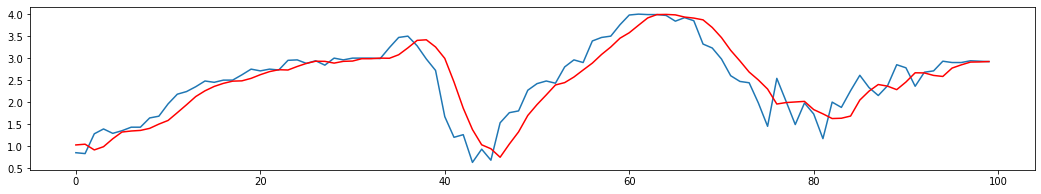

In [54]:
# zoom plot

plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show();

#### Time Series Components

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

* Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
* Non-Systematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. These components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.

Our time series dataset may contain a trend. A trend is a continued increase or decrease in the series over time. There can be benefit in identifying, modeling, and even removing trend information from your time series dataset.

Time series datasets can contain a seasonal component. This is a cycle that repeats over time, such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models. There are many types of seasonality: time of day, daily, weekly, monthly, yearly etc. Identifying whether there is a seasonality component in your time series problem is subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

A time series where the seasonal component has been removed is called seasonal stationary. If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

#### Stationarity in Time Series Data

The observations in a stationary time series are not dependent on time. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective.

#### Check for Stationarity

There are many methods to check whether a time series (direct observations, residuals, otherwise) is stationary or non-stationary.

* Look at Plots: You can review a time series plot of your data and visually check if there are any obvious trends or seasonality.
* Summary Statistics: You can review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences.
* Statistical Tests: You can use statistical tests to check if the expectations of stationarity are met or have been violated.

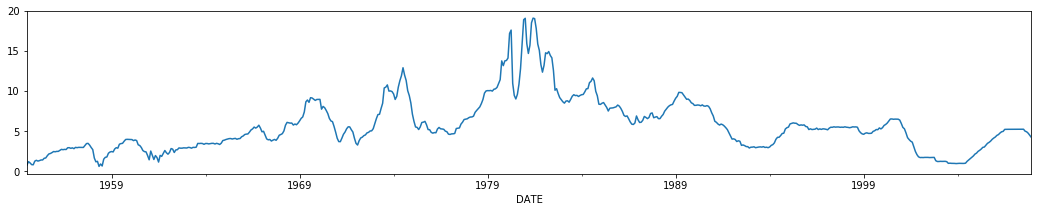

In [55]:
s.plot();

#### Augmented Dickey-Fuller test

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

In [56]:
# calculate stationarity test of time series data

X = s.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.185298
p-value: 0.020852
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


### A Gentle Introduction to Handling a Non-Stationary Time Series in Python

Other Source: <a> https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/ <a>

#### Table of contents

1. Methods to Check Stationarity

      * ADF Test
      * KPSS Test
        
        
2. Types of Stationarity

      * Strict Stationary
      * Trend Stationary
      * Difference Stationary
        
        
3. Making a Time Series Stationary

      * Differencing
      * Seasonal Differencing
      * Log transform

#### 1. Methods to Check Stationarity

#### Visual test

We can plot the data and determine if the properties of the series are changing with time or not.

In [57]:
s_new = s[:]  

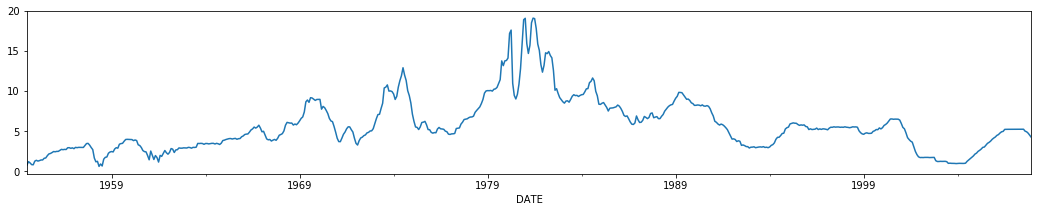

In [58]:
s_new.plot();

Although its very clear that we have a trend (varying mean) in the above series, this visual approach might not always give accurate results. It is better to confirm the observations using some statistical tests.

#### Statistical test

Instead of going for the visual test, we can use statistical tests like the unit root stationary tests. Unit root indicates that the statistical properties of a given series are not constant with time, which is the condition for stationary time series. Here is the mathematics explanation of the same :

Suppose we have a time series :

yt = a*yt-1 + ε t

where yt is the value at the time instant t and ε t is the error term. In order to calculate yt we need the value of yt-1, which is :

yt-1 = a*yt-2 + ε t-1

If we do that for all observations, the value of yt will come out to be:

yt = an*yt-n + Σεt-i*ai

If the value of a is 1 (unit) in the above equation, then the predictions will be equal to the yt-n and sum of all errors from t-n to t, which means that the variance will increase with time. This is knows as unit root in a time series. We know that for a stationary time series, the variance must not be a function of time. The unit root tests check the presence of unit root in the series by checking if value of a=1. Below are the two of the most commonly used unit root stationary tests:

#### ADF (Augmented Dickey Fuller) Test

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

* Null Hypothesis: The series has a unit root (value of a =1)

* Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary (we will understand more about difference stationary in the next section).

In [59]:
# define function for ADF test

# from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(s_new)

Results of Dickey-Fuller Test:
Test Statistic                 -3.19
p-value                         0.02
#Lags Used                     16.00
Number of Observations Used   625.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


Test for stationarity: If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series. We will understand the trend stationarity in detail in the next section. For now, let’s focus on the implementation and see the results of the KPSS test.

* Null Hypothesis: The process is trend stationary.

* Alternate Hypothesis: The series has a unit root (series is not stationary).

In [60]:
#define function for kpss test

from statsmodels.tsa.stattools import kpss

#define KPSS

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        print(kpss_output)

In [61]:
#apply kpss test on the series
kpss_test(s_new)

Results of KPSS Test:
Test Statistic          0.55
p-value                 0.03
Lags Used              20.00
Critical Value (10%)    0.35
dtype: float64
Test Statistic          0.55
p-value                 0.03
Lags Used              20.00
Critical Value (10%)    0.35
Critical Value (5%)     0.46
dtype: float64
Test Statistic           0.55
p-value                  0.03
Lags Used               20.00
Critical Value (10%)     0.35
Critical Value (5%)      0.46
Critical Value (2.5%)    0.57
dtype: float64
Test Statistic           0.55
p-value                  0.03
Lags Used               20.00
Critical Value (10%)     0.35
Critical Value (5%)      0.46
Critical Value (2.5%)    0.57
Critical Value (1%)      0.74
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Test for stationarity: If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). For our case, the value of the test statistic is greater than or equal to the critical value at 10% and 5% confidence intervals, and hence we can say that the series is not stationary at 2.5% and 1% confidence level.

I usually perform both the statistical tests before I prepare a model for my time series data. It once happened that both the tests showed contradictory results. One of the tests showed that the series is stationary while the other showed that the series is not! I got stuck at this part for hours, trying to figure out how is this possible. As it turns out, there are more than one type of stationarity.

So in summary, the ADF test has an alternate hypothesis of linear or difference stationary, while the KPSS test identifies trend-stationarity in a series.

#### 2. Types of Stationarity

Let us understand the different types of stationarities and how to interpret the results of the above tests.

* Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.
* Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
* Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

* Case 1: Both tests conclude that the series is not stationary -> series is not stationary
* Case 2: Both tests conclude that the series is stationary -> series is stationary
* Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
* Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

#### 3. Making a Time Series Stationary

Now that we are familiar with the concept of stationarity and its different types, we can finally move on to actually making our series stationary. Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first.

#### Differencing

In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

yt‘ = yt – y(t-1)

where yt is the value at a time t

Applying differencing on our series and plotting the results:

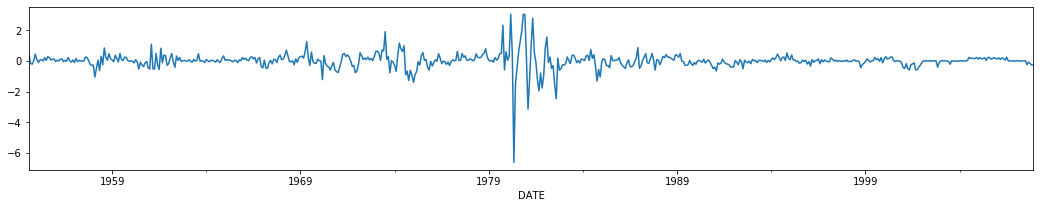

In [62]:
s_new['#Values_diff'] = s_new - s_new.shift(1)
s_new['#Values_diff'].dropna().plot();

Seasonal Differencing
In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

yt‘ = yt – y(t-n)

### Evaluate Models

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.

In time series forecasting, this evaluation of models on historical data is called backtesting. We will look at three different methods that you can use to backtest your machine learning models on time series problems:

1. Train-Test split that respects temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.

#### Train-Test Split

In [63]:
# calculate a train-test split of a time series dataset

X = s.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

In [64]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 642
Training Observations: 423
Testing Observations: 219


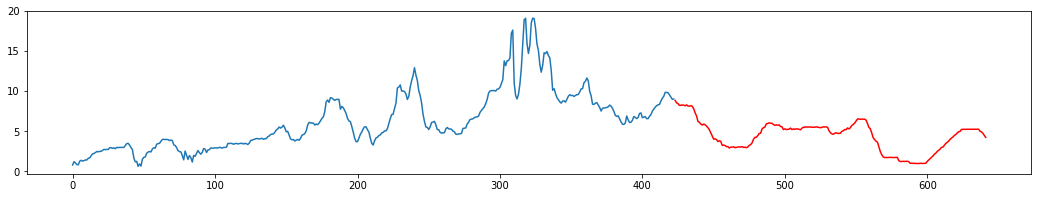

In [65]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');

#### Multiple Train-Test Splits

We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the train-split tests with different split points.

The scikit-learn library provides a time series "cross-validator" in the TimeSeriesSplit module. It provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

Observations: 322
Training Observations: 162
Testing Observations: 160
-----
Observations: 482
Training Observations: 322
Testing Observations: 160
-----
Observations: 642
Training Observations: 482
Testing Observations: 160
-----


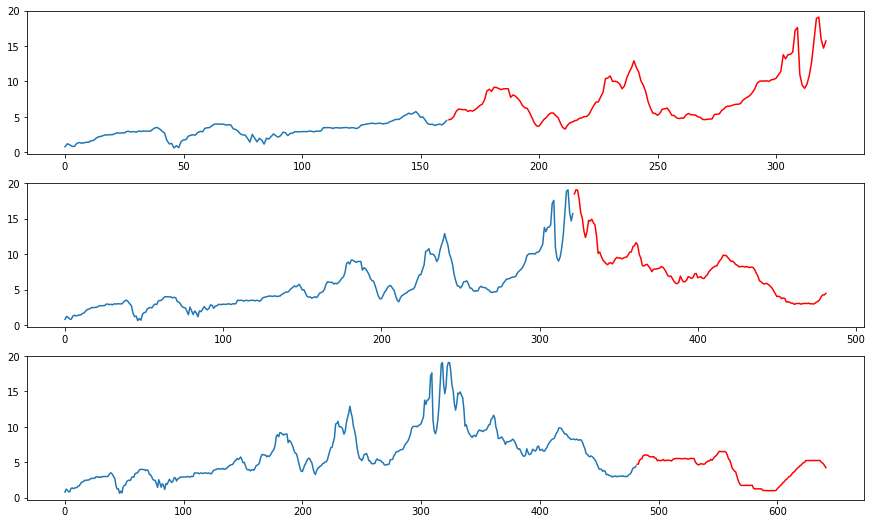

In [117]:
# calculate repeated train-test splits of time series data

X = s.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1
plt.show() 

Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data. A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available.

#### Persistence Model for Forecasting

Establishing a baseline is essential on any time series forecasting problem. A baseline in performance gives you an idea of how well all other models will actually perform on your problem. Here we will develop a persistence forecast that we can use later as a baseline level of performance on this time series dataset.

The following steps are required:

1. Transform the univariate dataset into a supervised learning problem.
2. Establish the train and test datasets for the test harness.
3. Define the persistence model.
4. Make a forecast and establish a baseline performance.
5. Review the complete example and plot the output.

In [66]:
# Create lagged dataset

values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [67]:
# split into train and test sets
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [68]:
# persistence model
def model_persistence(x):
    return x

In [69]:
# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))

In [70]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.187


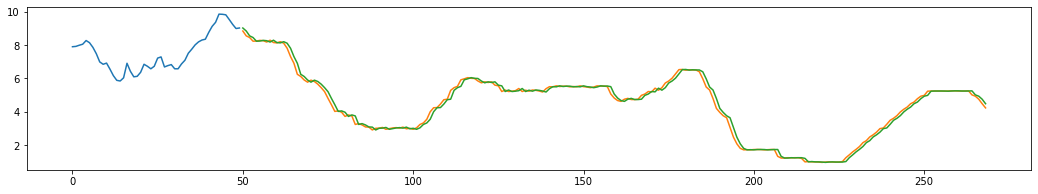

In [71]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])

#### Visualize Residual Forecast Errors

Forecast errors on a time series forecasting problem are called residual errors or residuals. A residual error is calculated as the expected outcome minus the forecast. Careful exploration of residual errors on your time series prediction problem can tell you a lot about your forecast model and even suggest improvements.

In [72]:
# calculate residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)

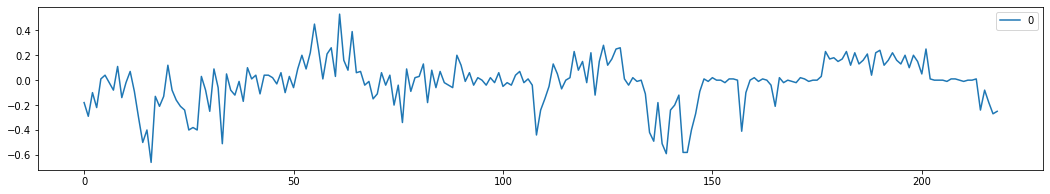

In [73]:
# plot residuals
residuals.plot();

We can calculate summary statistics on the residual errors. Primarily, we are interested in the mean value of the residual errors. A value close to zero suggests no bias in the forecasts, whereas positive and negative values suggest a positive or negative bias in the forecasts made. It is useful to know about a bias in the forecasts as it can be directly corrected in forecasts prior to their use or evaluation.

In [74]:
residuals.describe()

,0
count,219.00
mean,-0.02
std,0.19
min,-0.66
25%,-0.09
50%,0.00
75%,0.08
max,0.53


Plots can be used to better understand the distribution of errors beyond summary statistics. We would expect the forecast errors to be normally distributed around a zero mean

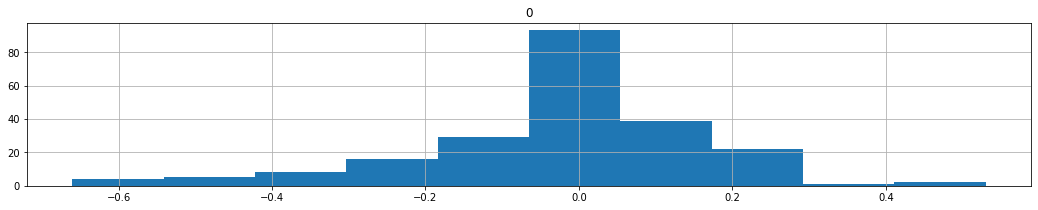

In [75]:
# histograms plot
residuals.hist();

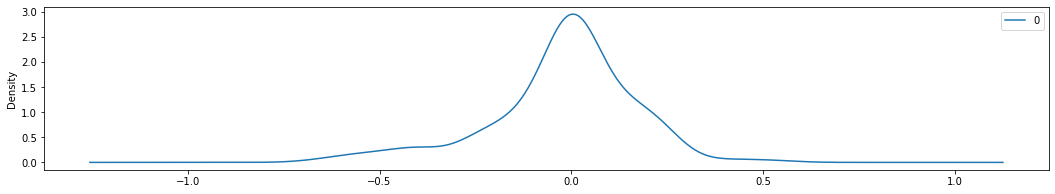

In [76]:
# density plot
residuals.plot(kind='kde');

#### Residual Q-Q Plot

A Q-Q plot, or quantile plot, compares two distributions and can be used to see how similar or different they happen to be. The Q-Q plot can be used to quickly check the normality of the distribution of residual errors. The values are ordered and compared to an idealized Gaussian distribution. The comparison is shown as a scatter plot (theoretical on the x-axis and observed on the y-axis) where a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.

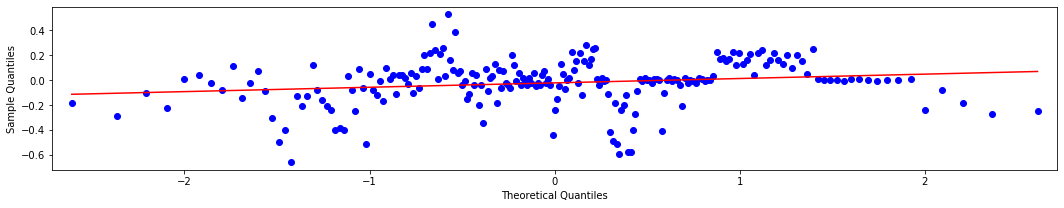

In [77]:
qqplot(residuals, line='r')
plt.show()

#### Residual Autocorrelation Plot

We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot). A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression.

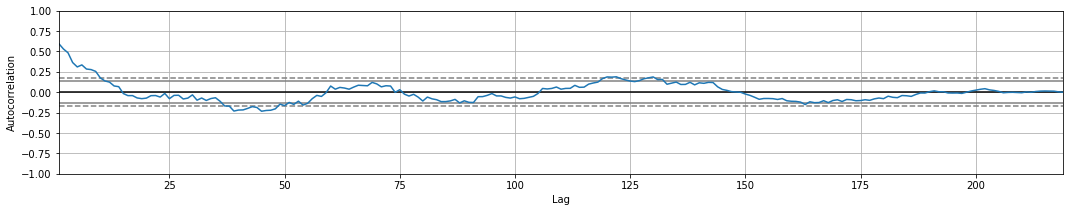

In [78]:
autocorrelation_plot(residuals);

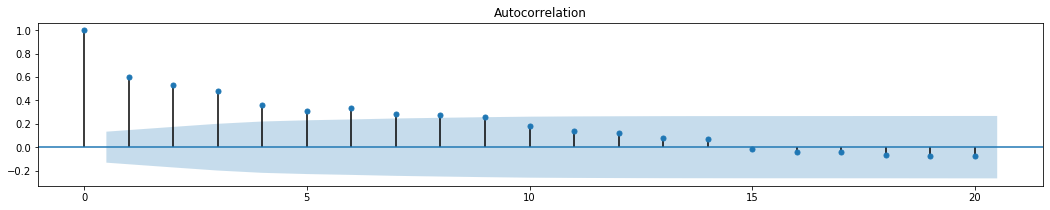

In [79]:
# autocorrelation plot of residuals as a line plot

plot_acf(residuals, lags=20)
plt.show()

#### Reframe Time Series Forecasting Problems

There are many ways to reframe the forecast problem that can both simplify the prediction problem and potentially expose more or different information to be modeled. A reframing can ultimately result in better and/or more robust forecasts.

#### Classification Framings

Classification involves predicting categorical or label outputs (such as high, medium, and low). For example, we can forecast whether a change in minimum value will be small or large, or whether the new value will be lower or higher than the current value.

In [80]:
# Create lagged dataset

values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

In [81]:
def make_discrete(row):
    if row['t+1'] < 0:
        return 'low'
    elif row['t+1'] > 3:
        return 'high'
    else:
        return 'medium'

In [82]:
# apply the above function to reassign t+1 values
df['t+1'] = df.apply(lambda row: make_discrete(row), axis=1)

In [83]:
# Randomly sample 10 elements from the dataframe
df.sample(n=10)

,t,t+1
282,6.56,high
435,8.20,high
567,3.07,medium
1,0.80,medium
531,5.51,high
87,1.88,medium
347,8.63,high
7,1.39,medium
311,10.98,high
86,2.00,medium


#### Time Horizon Framings

* Forecast the minimum value for the next 3 months.
* Forecast the maximum value relative to the average from the past 12 months.
* Forecast the month in the next year that will have the lowest value.
* ...

In [84]:
# create lagged dataset
values = pd.DataFrame(s.values)
df = pd.concat([values.shift(1), values, values.shift(-1), values.shift(-2)], axis=1)
df.columns = ['t', 't+1', 't+2', 't+3']

In [85]:
df.head()

,t,t+1,t+2,t+3
0,nan,0.80,1.22,1.06
1,0.80,1.22,1.06,0.85
2,1.22,1.06,0.85,0.83
3,1.06,0.85,0.83,1.28
4,0.85,0.83,1.28,1.39


#### ARIMA Model for Forecasting

The Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis. An ARIMA model is a class of statistical model for analyzing and forecasting time series data.

ARIMA is an acronym that stands for Autoregressive Integrated Moving Average Model. This acronym is descriptive, capturing the key aspects of the model itself:

* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

Let's start off with something simple. We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.

In [86]:
# fit model
model = ARIMA(s, order=(5,1,0))
model_fit = model.fit(disp=0)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [87]:
# summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  641
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -461.593
Method:                       css-mle   S.D. of innovations              0.497
Date:                Fri, 04 Sep 2020   AIC                            937.186
Time:                        10:21:17   BIC                            968.427
Sample:                    08-01-1954   HQIC                           949.312
                         - 12-01-2007                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.024      0.236      0.813      -0.042       0.053
ar.L1.D.y      0.4299      0.040     10.882      0.000       0.352       0.507
ar.L2.D.y     -0.1598      0.043     -3.729      0.0

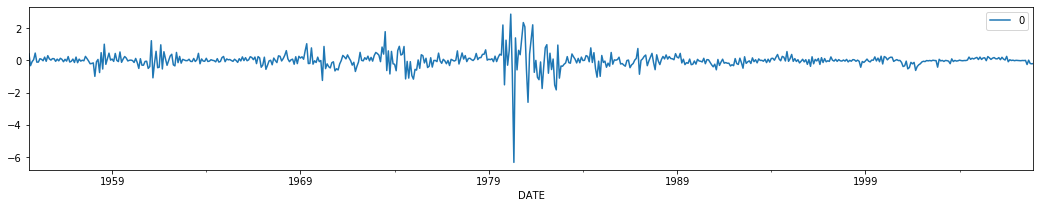

In [88]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

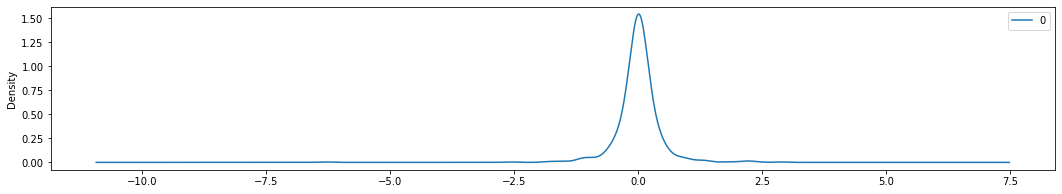

In [89]:
# density plot of residuals
residuals.plot(kind='kde');

[(-2, 2)]

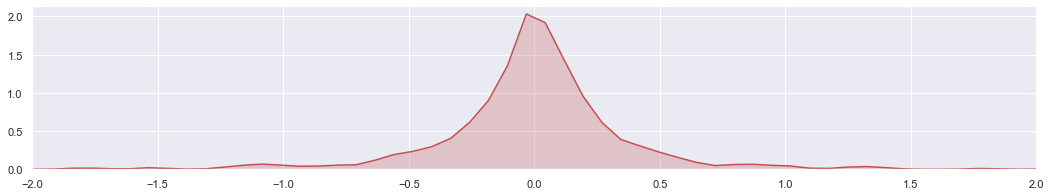

In [90]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

In [91]:
# summary stats of residuals
residuals.describe()

,0
count,641.00
mean,-0.00
std,0.50
min,-6.32
25%,-0.13
50%,-0.00
75%,0.14
max,2.88


#### Rolling Forecast ARIMA Model

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

In [92]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received. We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

In [93]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

We can calculate a final root mean squared error score (RMSE) for the predictions, providing a point of comparison for other ARIMA configurations.

In [94]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.175


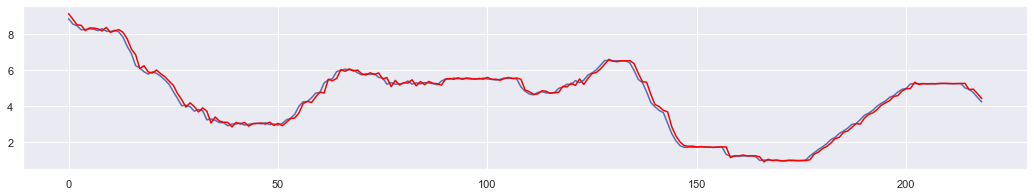

In [95]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

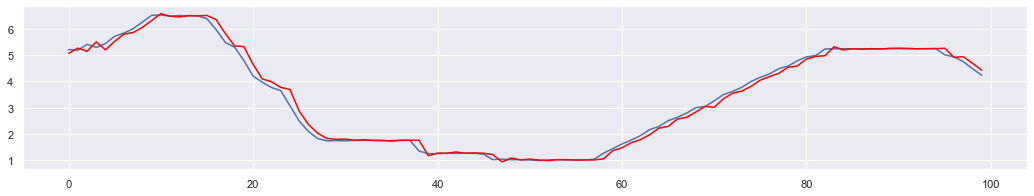

In [96]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show();

### Grid Search ARIMA Model Hyperparameters

In [97]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [98]:
# evaluate parameters
p = 3
d = 1
q = 0
order = (p, d, q)
evaluate_arima_model(s.values, order)

0.16940482237464494

In [99]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [100]:
import warnings
warnings.filterwarnings("ignore")

In [101]:
# evaluate parameters
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(s.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.435
ARIMA(0, 0, 1) RMSE=1.268
ARIMA(0, 1, 0) RMSE=0.189
ARIMA(0, 1, 1) RMSE=0.165
ARIMA(1, 0, 0) RMSE=0.187
ARIMA(1, 0, 1) RMSE=0.165
ARIMA(1, 1, 0) RMSE=0.157
ARIMA(1, 1, 1) RMSE=0.163
ARIMA(2, 0, 0) RMSE=0.157
ARIMA(2, 0, 1) RMSE=0.163
ARIMA(2, 1, 0) RMSE=0.168
ARIMA(2, 1, 1) RMSE=0.177
Best ARIMA(1, 1, 0) RMSE=0.157


#### Rolling Forecast with Selected ARIMA Model: Walk Forward Validation

ARIMA(1, 1, 0) performed best and we select it for our final model.

In [102]:
# split into train and test sets
X = s.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [103]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [104]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.157


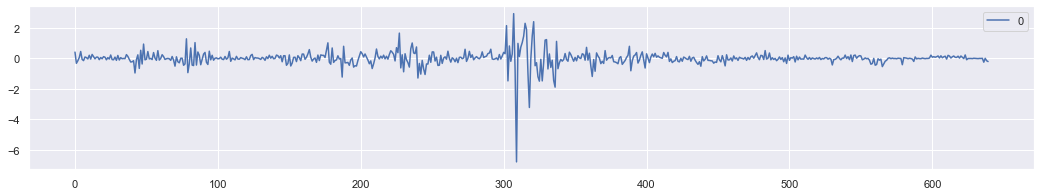

In [105]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

[(-2, 2)]

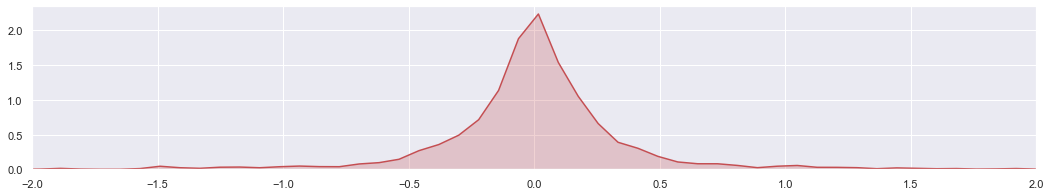

In [106]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

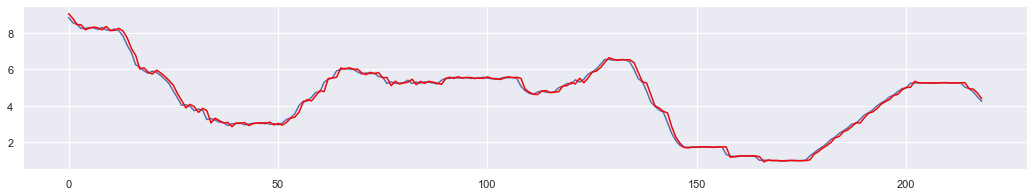

In [107]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red');

Let's just quickly review which part of the time series we were evaluating.

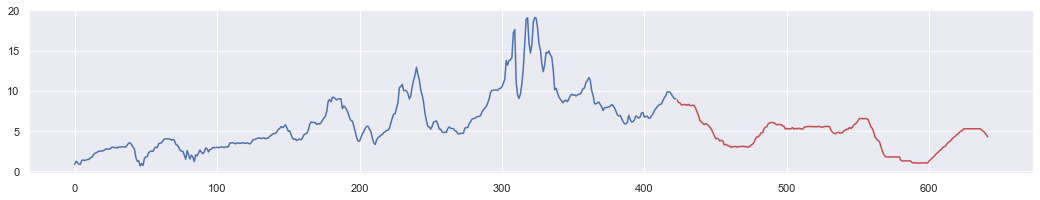

In [108]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r');